In [2]:
import pandas as pd
import pickle

with open ('season_data.pickle','rb') as file:
    data = pickle.load(file)

managers = data["managers"]

In [4]:
standings_w2w = pd.DataFrame(columns=["manager","h2h points", "points", "gw"])

for man in managers:
    h2h_pts = 0
    for gw in range(1,30):
        pts = man.fixtures[gw]["points"]
        if man.fixtures[gw]["result"] == "W":
            h2h_pts += 3
        elif man.fixtures[gw]["result"] == "D":
            h2h_pts += 1
        standings_w2w.loc[standings_w2w.shape[0]] = {"manager":man.short_name,"h2h points":h2h_pts, "points":pts, "gw":gw}

df = standings_w2w.pivot(index="gw",columns="manager",values="h2h points")
row_means = df.mean(axis=1)
avg_dist = df.sub(row_means, axis=0)

In [8]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def create_graph(man1,man2):
    highlighted_managers = [man1,man2]

    # Interpolation setup
    original_x = avg_dist.index.values
    dense_x = np.linspace(original_x.min(), original_x.max(), 300)  # more frames

    # Interpolate data
    interpolated_data = {}
    for col in avg_dist.columns:
        f = interp1d(original_x, avg_dist[col].values, kind='linear')
        interpolated_data[col] = f(dense_x)

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 6))
    lines = {}
    for col in avg_dist.columns:
        is_highlighted = col in highlighted_managers
        color = None if is_highlighted else 'lightgrey'
        lines[col] = ax.plot([], [], label=col, color=color, 
                            linewidth=2 if is_highlighted else 1, 
                            alpha=1.0 if is_highlighted else 0.6)[0]

    ax.set_xlim(dense_x.min(), dense_x.max())
    ax.set_ylim(avg_dist.min().min(), avg_dist.max().max())
    ax.legend(loc='upper left')
    ax.set_xlabel("Gameweek")
    ax.set_ylabel("Distance to Average")

    def init():
        for line in lines.values():
            line.set_data([], [])
        return lines.values()

    def update(frame):
        x_vals = dense_x[:frame]
        for col in avg_dist.columns:
            y_vals = interpolated_data[col][:frame]
            lines[col].set_data(x_vals, y_vals)
        return lines.values()

    ani = FuncAnimation(fig, update, frames=len(dense_x)+1, init_func=init,
                        blit=True, interval=30, repeat=False)

    ani.save(f"graphs/{man1}-{man2}_h2h.gif", writer="pillow", fps=30)
    print(f"Finished {man1} vs {man2}")

Finished AA vs ES
Finished SL vs SS
Finished RK vs YA1
Finished YE vs YA
Finished WN vs SB
Finished pa vs AB
Finished KS vs ST


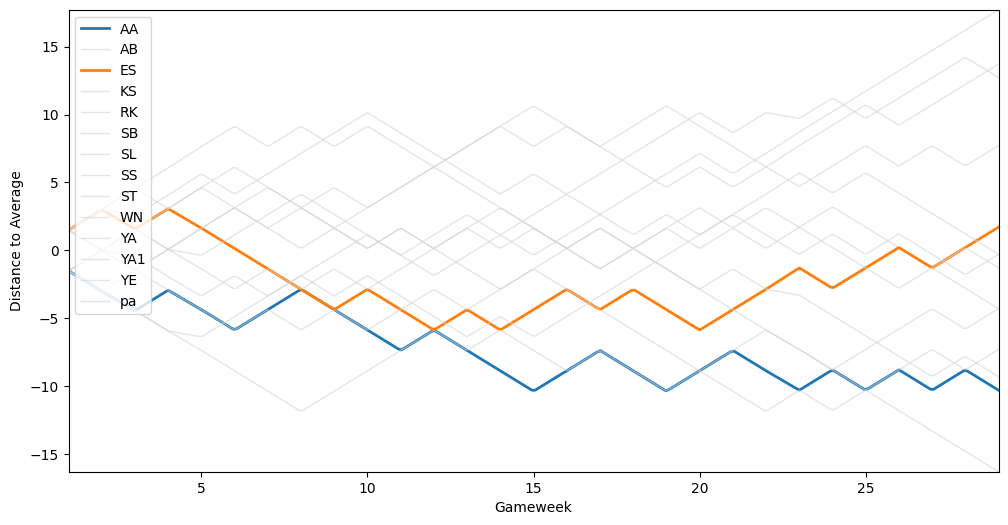

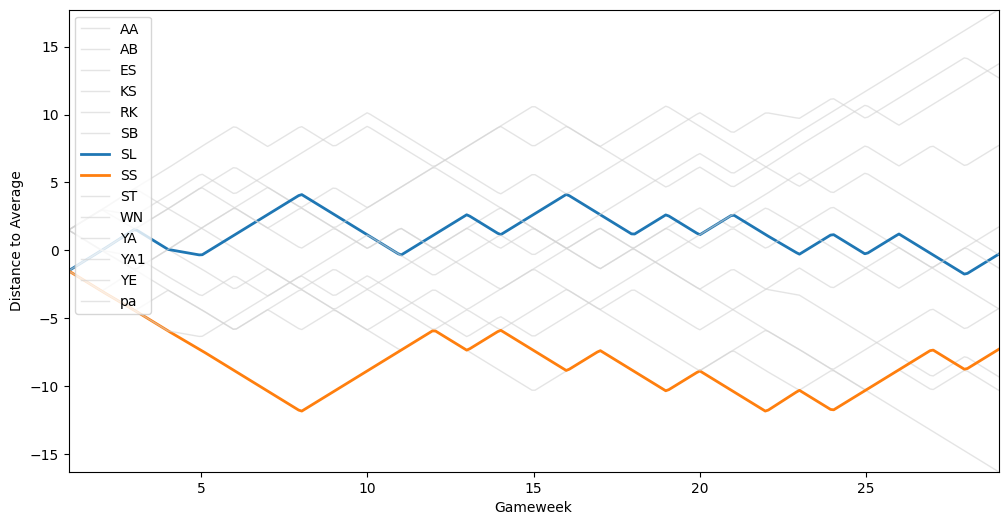

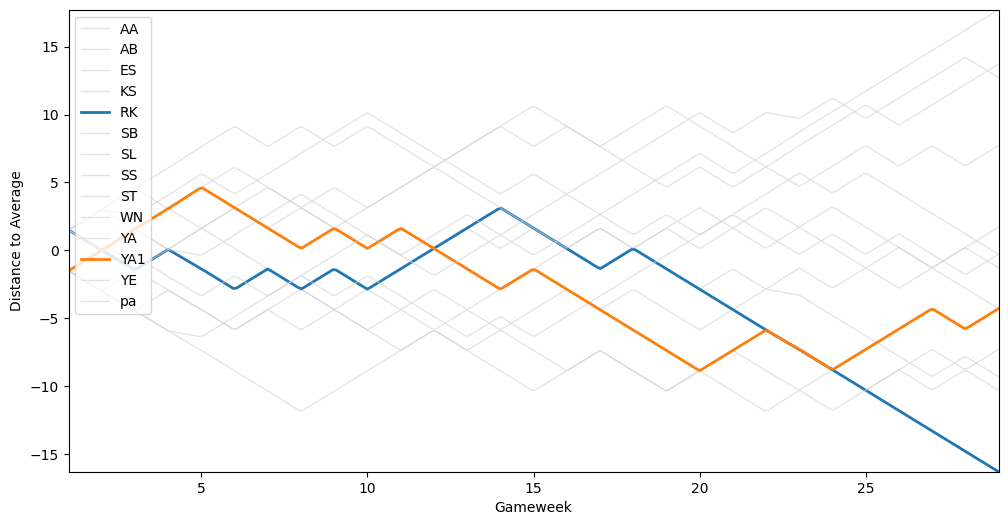

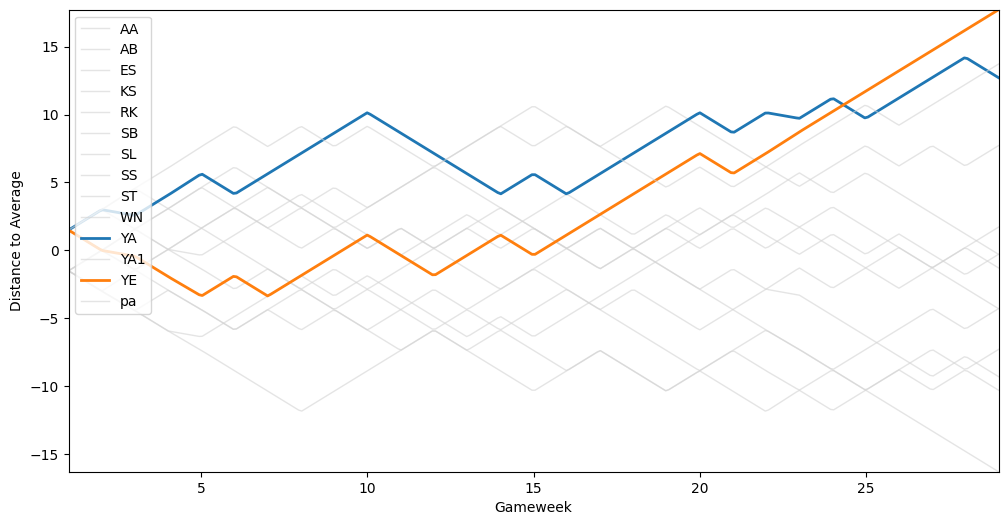

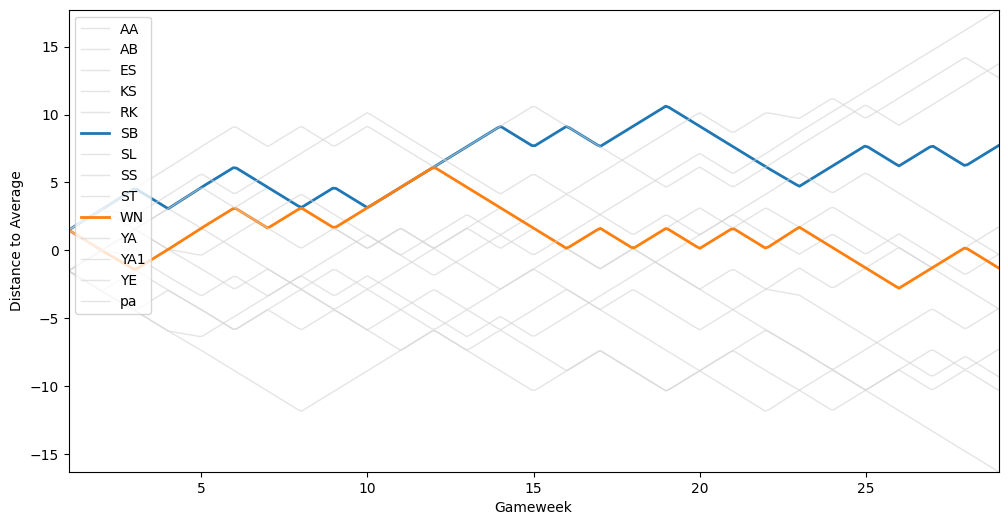

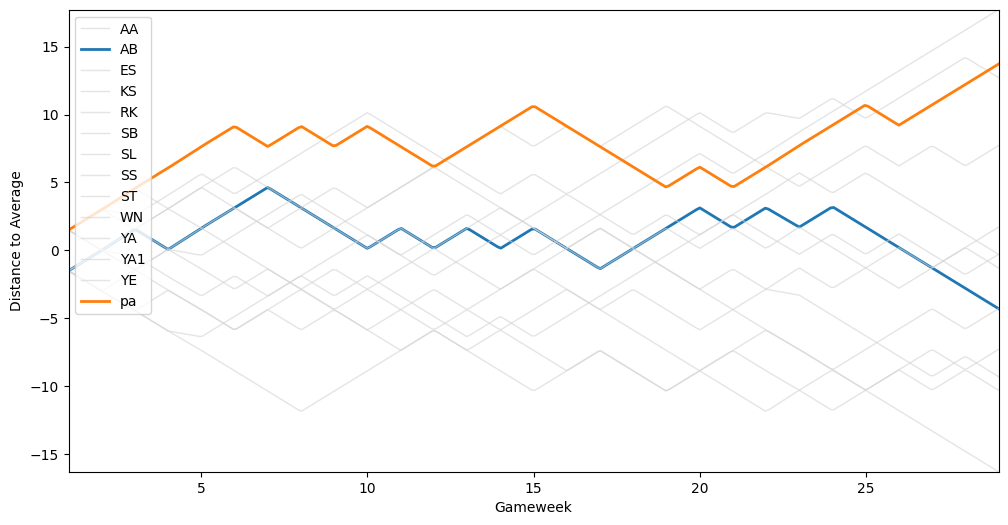

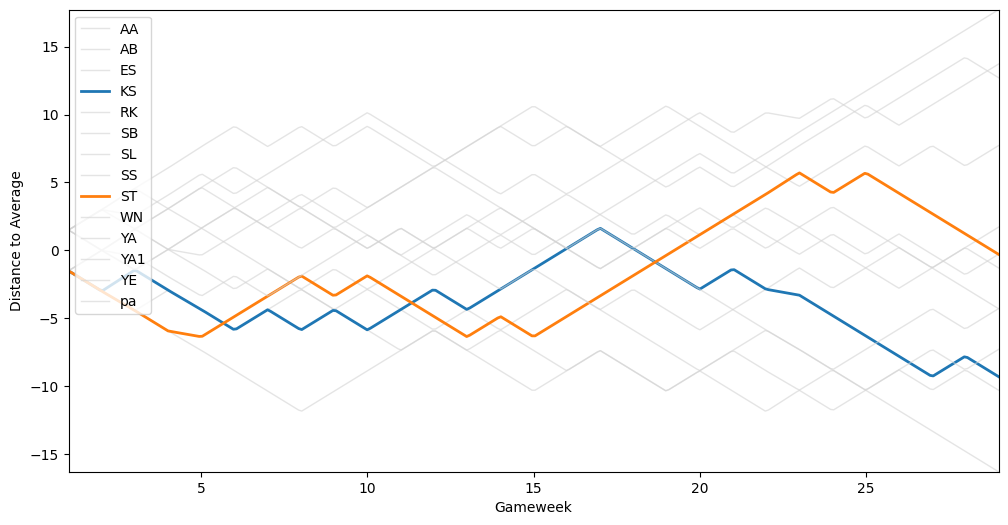

In [9]:
pairs = [("AA","ES"),("SL","SS"),("RK","YA1"),("YE","YA"),("WN","SB"),("pa","AB"),("KS","ST")]

for pair in pairs:
    create_graph(pair[0],pair[1])